![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/6.2.SparkOcrRestApi.ipynb)

# Spark OCR Rest API

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=True
nlp.install(refresh_install=True, visual=True)

In [ ]:
import pyspark
import json
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

## Start Spark session

In [ ]:
conf = {"spark.jars.packages": "com.microsoft.azure:synapseml_2.12:0.11.3",
   "spark.jars.repositories": "https://repo1.maven.org/maven2,https://mmlspark.azureedge.net/maven"}


# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True, spark_conf=conf)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8542 (4).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.3.1, 💊Spark-Healthcare==5.3.1, 🕶Spark-OCR==5.3.1, running on ⚡ PySpark==3.4.0


## Define Spark OCR pipeline

In [ ]:
import synapse.ml
from synapse.ml.io import *
import pyspark
from pyspark.sql.functions import udf, col, length, lit
from pyspark.sql.types import *
from pyspark.ml import PipelineModel
from sparkocr.transformers import *


binary_to_image = visual.BinaryToImage()

ocr = visual.ImageToText() \
   .setOutputCol("text")

pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr
])

In [ ]:
SERVER_HOST = "localhost"
SERVER_PORT = 8891
SERVER_API_NAME = "spark_ocr_api"

## Start server

In [ ]:
import tempfile
checkpoint_dir = tempfile.TemporaryDirectory("_spark_ocr_server_checkpoint")

df = spark.readStream.server() \
    .address(SERVER_HOST, SERVER_PORT, SERVER_API_NAME) \
    .load() \
    .parseRequest(SERVER_API_NAME, schema=StructType().add("image", BinaryType())) \
    .withColumn("path", lit("")) \
    .withColumnRenamed("image", "content")

replies = pipeline.transform(df)\
    .makeReply("text")

server = replies\
    .writeStream \
    .server() \
    .replyTo(SERVER_API_NAME) \
    .queryName("spark_ocr") \
    .option("checkpointLocation", checkpoint_dir) \
    .start()

print(f"Checkpoint: {checkpoint_dir}")

Checkpoint: <TemporaryDirectory '/tmp/tmpucngct22_spark_ocr_server_checkpoint'>


# Call API

Display image

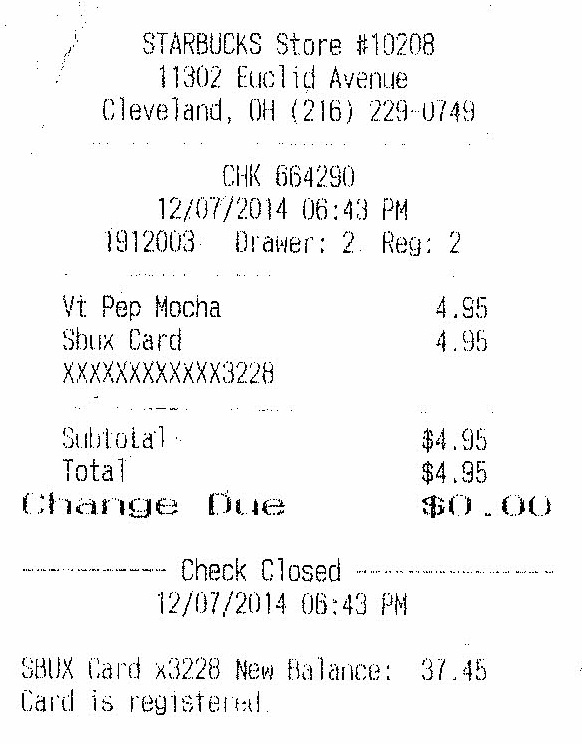

In [ ]:
import pkg_resources
import json
import base64
import requests
from IPython.display import Image

imagePath = pkg_resources.resource_filename('sparkocr', '/resources/ocr/images/check.jpg')

display(Image(filename=imagePath))

## Send request

In [ ]:
with open(imagePath, "rb") as image_file:
    im_bytes = image_file.read()

im_b64 = base64.b64encode(im_bytes).decode("utf8")

headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

payload = json.dumps({"image": im_b64})
r = requests.post(data=payload, headers=headers, url=f"http://{SERVER_HOST}:{SERVER_PORT}/{SERVER_API_NAME}")

print("Response:\n\n{}".format(r.text))

Response:

STARBUCKS Store #19208
11902 Euclid Avenue
Cleveland, OH (216) 229-U749

CHK 664250
12/07/2014 06:43 PM
112003. Drawer: 2. Reg: 2

¥t Pep Mocha 4.95

Sbux Card 4.95

AXKANRKAXERAK, 3228

Subtotal $4.95

Total $4.95
Change Cue BOC

- Check Closed ~
“12/01/2014 06:43 py

oBUX Card «3228 New Balance: 37.45
Card is registertd



## Stop server

In [ ]:
server.stop()